# Goal of Analysis

## 1. Decide a model that predicts monthly retention rate for the different subscription price points

## 2. Based on your model, for each price point, what percentage of users is still subscribed after at least 12 months?

## 3. How do user country and source affect subscription retention rate? How would you use these findings to improve the company revenue?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
data = pd.read_csv('subscription.csv')
data.head()

,user_id,subscription_signup_date,subscription_monthly_cost,country,source,billing_cycles,is_active
0,1459,"January, 2015",29,Spain,ads,4,0
1,12474,"January, 2015",49,France,ads,5,0
2,12294,"January, 2015",49,Germany,ads,2,0
3,3878,"January, 2015",49,China,ads,1,0
4,9567,"January, 2015",49,UK,ads,5,0


In [3]:
data.subscription_signup_date.unique

<bound method Series.unique of 0         January, 2015
1         January, 2015
2         January, 2015
3         January, 2015
4         January, 2015
              ...      
499995    January, 2015
499996    January, 2015
499997    January, 2015
499998    January, 2015
499999    January, 2015
Name: subscription_signup_date, Length: 500000, dtype: object>

Since the subscription_signup_date has only one value, which is January, 2015, I decide to delete this column

In [4]:
del data['subscription_signup_date']

data.head()

,user_id,subscription_monthly_cost,country,source,billing_cycles,is_active
0,1459,29,Spain,ads,4,0
1,12474,49,France,ads,5,0
2,12294,49,Germany,ads,2,0
3,3878,49,China,ads,1,0
4,9567,49,UK,ads,5,0


### Question 1

In [5]:
# I first groupby the monthly cost and then count the number for different billing cycles

count_by_cost = data.groupby('subscription_monthly_cost').apply(lambda df: df.billing_cycles.value_counts()).unstack()

count_by_cost

,1,2,3,4,5,6,7,8
subscription_monthly_cost,,,,,,,,
29,57441,21818,12037,7787,5505,4136,3111,34527
49,185145,53296,21690,11288,6727,4405,3173,14673
99,44788,4724,1471,678,399,226,156,799


In [6]:
# transpose the above result to get a better look

total_by_cost = count_by_cost.apply(lambda s: s.iloc[::-1].cumsum().iloc[::-1],axis=1).transpose()

total_by_cost

subscription_monthly_cost,29,49,99
1,146362,300397,53241
2,88921,115252,8453
3,67103,61956,3729
4,55066,40266,2258
5,47279,28978,1580
6,41774,22251,1181
7,37638,17846,955
8,34527,14673,799


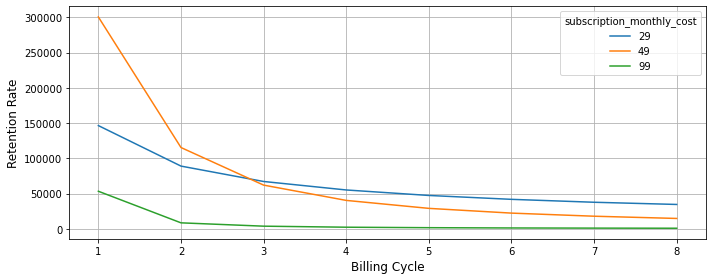

In [7]:
# visualization

fig, ax = plt.subplots(figsize=(10, 4))
total_by_cost.plot(kind='line', ax=ax)
ax.set_xlabel('Billing Cycle', fontsize=12)
ax.set_ylabel('Retention Rate', fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

We can know from the above graph:

1. for each 'subscription_monthly_cost', there are only 8 samples.

2. Our dataset is small. Since complex model will overfit on samll dataset, so I decide to use a simple Linear Regression model.

3. The remaining #subscribers by the end of each billing cycles has a nonlinear relationship with #billing_cycles as shown from the graph, so I need to include some nonlinear transformation of 'billing_cycles'

4. The target #subscribers should be non-negative, so I cannot fit on original target, so I will try on log(#subscribers). After obtaining the fitted value, we transform back to '#subscribers' by exp(), which can guarantee a positive result.

In [8]:
from sklearn.linear_model import LinearRegression

def make_time_features(t):
    """
    three features:
    1. t: #cycles
    2. t-square: square of #cycles
    3. logt: log(#cycles)
    """
    return pd.DataFrame({'t': t,'logt': np.log(t),'tsquare':t*t },index = t)

def fit_linear_regression(s):
    """
    target:
    log(s): s is #subscribers left by the end of each billing cycle
    do this transformation, to guarantee that, after tranforming back, the fitted result is always positive
    """
    X = make_time_features(s.index)
    return LinearRegression().fit(X,np.log(s))

In [9]:
lr_by_cost = total_by_cost.apply(fit_linear_regression,axis=0)

In [10]:
allt = np.arange(1,13)
Xwhole = make_time_features(allt)
Xwhole

,t,logt,tsquare
1,1,0.000000,1
2,2,0.693147,4
3,3,1.098612,9
4,4,1.386294,16
5,5,1.609438,25
6,6,1.791759,36
7,7,1.945910,49
8,8,2.079442,64
9,9,2.197225,81
10,10,2.302585,100


In [11]:
# call each cost's model to fit on above features

predicts = lr_by_cost.apply(lambda lr: pd.Series(lr.predict(Xwhole),index=allt)).transpose()
predicts = predicts.applymap(np.exp)

predicts

subscription_monthly_cost,29,49,99
1,146289.043583,301551.603773,52816.489536
2,89078.661927,113569.323151,8700.570325
3,67048.510837,62560.448086,3678.850952
4,54997.715283,40592.309531,2210.169591
5,47259.987332,28988.345871,1567.465186
6,41802.132010,22106.115832,1208.305347
7,37703.792361,17713.678002,968.806877
8,34484.309114,14771.777457,786.979952
9,31866.862280,12740.560957,636.784748
10,29680.233950,11317.105659,507.336931


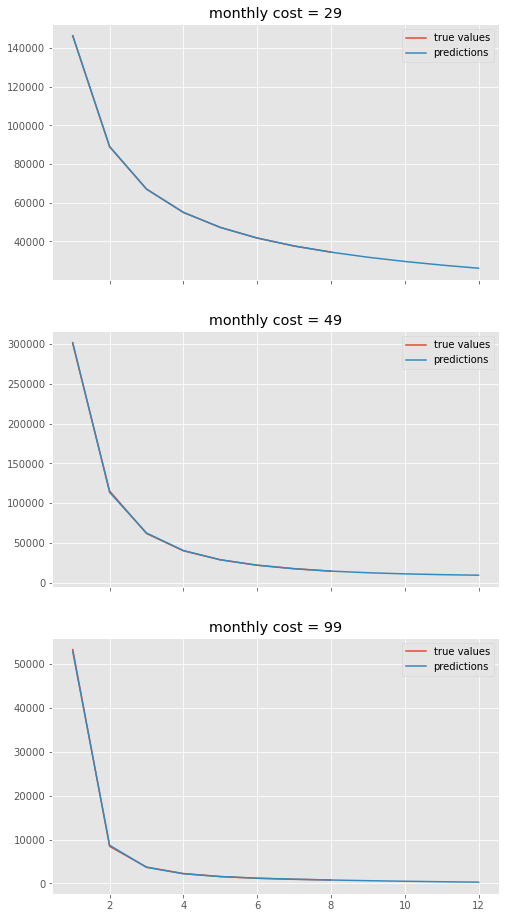

In [19]:
fig,axes = plt.subplots(3,1,sharex=True)
plt.style.use('ggplot')

monthly_costs = [29,49,99]

for index,cost in enumerate(monthly_costs):
    ax = axes[index]
    total_by_cost.loc[:,cost].plot(ax = ax,label='true values')
    predicts.loc[:,cost].plot(ax=ax,label='predictions')
    ax.legend(loc='best')
    ax.set_title('monthly cost = {}'.format(cost))
plt.rc('figure',figsize=(10,16))

### Question 2

In [13]:
# In order to calculate the percentage, we just need to divide the last predicted value to the total values

predicts.loc[12,:]/predicts.loc[1,:]

subscription_monthly_cost
29    0.179014
49    0.031984
99    0.005644
dtype: float64

### Question 3

In order to know the the influence of countr and source to the subscription rate, we first define a new function to calculate the retention rate and then apply to country and source to see the result.

In [14]:
def retention_rate(df):
    total_num = len(df)
    rate = []
    for i in [1, 2, 3, 4, 5, 6, 7, 8]:
        rate.append(len(df[df['billing_cycles'] >= i]) / total_num)
        
    return pd.Series(rate, index=[1, 2, 3, 4, 5, 6, 7, 8])

In [15]:
# calculate the retention rate for each montly cost for different countries

grouped = data.groupby('country').apply(retention_rate)
grouped

,1,2,3,4,5,6,7,8
country,,,,,,,,
China,1.0,0.514831,0.402777,0.360426,0.336274,0.319856,0.307084,0.295453
France,1.0,0.334946,0.177732,0.119004,0.088479,0.069935,0.058341,0.049688
Germany,1.0,0.451284,0.278411,0.195910,0.146474,0.115151,0.093868,0.078465
India,1.0,0.446728,0.326962,0.284527,0.261603,0.246736,0.234847,0.225769
Italy,1.0,0.341684,0.179502,0.119914,0.090015,0.071135,0.057523,0.048695
Spain,1.0,0.339098,0.178985,0.119879,0.088648,0.070065,0.057617,0.048503
UK,1.0,0.458938,0.285133,0.198067,0.149421,0.117356,0.095735,0.079494
US,1.0,0.456509,0.284255,0.198853,0.149284,0.117398,0.094875,0.078981


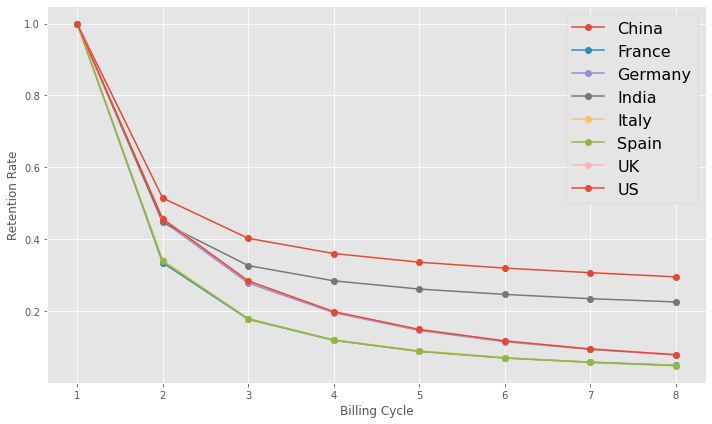

In [16]:
# visualization

fig, ax = plt.subplots(figsize=(10, 6))
grouped.T.plot(kind='line', marker='o', ax=ax)
ax.set_xlabel('Billing Cycle', fontsize=12)
ax.set_ylabel('Retention Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=16)
plt.tight_layout()
plt.show()

From the country graph, we can see that:

1. customers from China and Indian are most loyal ones. Their retention rate is high and the 'dropping rate' is slow. To increase the revenue, we should keep tight touch to customers in China and Indian. for examples, sending coupons to them from time to time.

2. UK, US, Germany has medium 'retention rate'. France, Italy, Spain has the lowest 'retention rate'. Possible reasons maybe because the poor economic conditions in these countries. We could consider lowering the 'monthly cost' in these countries, to keep more customers maintain subscription.

In [17]:
# calculate the retention rate for each montly cost for different sources

grouped = data.groupby('source').apply(retention_rate)
grouped

,1,2,3,4,5,6,7,8
source,,,,,,,,
ads,1.0,0.388873,0.222094,0.152607,0.114959,0.092043,0.076756,0.066237
friend_referral,1.0,0.699443,0.617038,0.561282,0.519854,0.487596,0.461110,0.436507
seo,1.0,0.562395,0.420012,0.337594,0.286254,0.247877,0.218680,0.194475


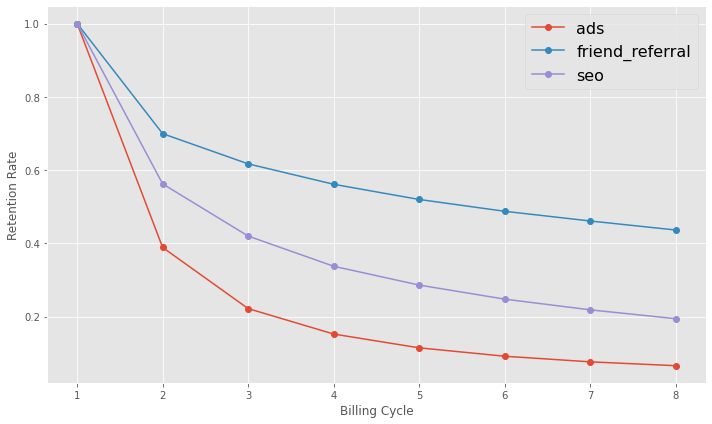

In [18]:
# visualization

fig, ax = plt.subplots(figsize=(10, 6))
grouped.T.plot(kind='line', marker='o', ax=ax)
ax.set_xlabel('Billing Cycle', fontsize=12)
ax.set_ylabel('Retention Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=16)
plt.tight_layout()
plt.show()

From the source influence, we can see that:

1. Subscribers from 'friend_referral' are the most loyal, way more loyal then subscribers from advertisement and search engine.

2. To improve the revenue, we can launch some program to improve 'user referral'. For example, current subscribers can invite new users to subscribe. If your friends subscribe after your referral, you can get certain amounts of rewards.